In [1]:
import numpy as np
import random
import numpy 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mindspore as ms
from mindspore import context
from mindspore import Tensor
from mindspore import nn
from mindspore.train import Model

In [34]:
context.set_context(mode=context.PYNATIVE_MODE,device_target="CPU")

In [25]:
# 读取训练数据，这里有3个注意点：
# 1.需要把数据都转成ms.float32，因为定义网络结构时，默认生成的权重都是ms.float32类型的
# 2.由于使用mindspore.dataset.GeneratorDataset把数据集转成合适的格式时，接收的数据格式为[[x1,y1],[x2,y2],...],因此读取数据时要按这个格式存储数据
# 3.不要转化成np.array，否则用ms.dataset.GeneretorDataset后无法用create_dict_generator()获取分batch后的数据值
def readData(path):
    lines=open(path,"r",encoding="utf-8").readlines()
    train_X=[]
    for l in lines:
        data=l.strip().split(" ")
        tmp=[]
        x=[]
        # x.append(Tensor(float(data[0]),ms.float32))
        # x.append(Tensor(float(data[1]),ms.float32))
        x.append(float(data[0]))
        x.append(float(data[1]))
        tmp.append(Tensor(x,ms.float32))
        tmp.append(Tensor(float(data[2]),ms.float32))
        train_X.append(tmp)
    return train_X    

In [39]:
train_data=readData("paraboloid_train.txt")

In [28]:
# 定义数据增强函数，这一步就是把数据集转换成ms.model.train可以接受的数据格式
# ds.GeneratorDataset可以接受的格式为一个list，list的格式为[[x1,y1],[x2,y2],...]
from mindspore import dataset as ds
def create_dataset(data,batch_size=4):
    input_data=ds.GeneratorDataset(data,column_names=["data","label"],column_types=[ms.float32,ms.float32])
    input_data=input_data.batch(batch_size)
    return input_data

In [93]:
train_data[0]

[Tensor(shape=[2], dtype=Float32, value= [-2.78748798e+00,  1.89456999e-01]),
 Tensor(shape=[], dtype=Float32, value= 10.4924)]

In [40]:
ds_train=create_dataset(train_data)

In [120]:
cnt=0
for i in ds_train.create_dict_iterator():
    print(i["data"],["label"])
    cnt+=1
    if cnt==3:
        break

[[-1.488733  0.813105]
 [-1.306542  0.948683]
 [-1.602986  0.774939]
 [-1.747625  0.650534]] ['label']
[[ 1.24902   2.184008]
 [ 2.418357  2.731053]
 [-0.397911  1.36113 ]
 [ 0.652414  1.893533]] ['label']
[[-0.466731  1.407431]
 [-1.747288  0.671124]
 [-2.635364  0.209559]
 [ 1.750913  2.453472]] ['label']


In [62]:
# 读取测试数据
def readTestData(path):
    f=open(path,"r",encoding="UTF-8").readlines()
    X=[]
    Y=[]
    for l in f:
        data=l.strip().split(" ")
        tmp=[]
        tmp.append(float(data[0]))
        tmp.append(float(data[1]))
        X.append(tmp)
        Y.append(float(data[2]))
    return Tensor(X,ms.float32),Tensor(Y,ms.float32) 

test1_X,test1_Y=readTestData("paraboloid_test1.txt")
test2_X,test2_Y=readTestData("paraboloid_test2.txt")
test3_X,test3_Y=readTestData("paraboloid_test3.txt")

# 1.基础部分

## 1.1双隐藏层的网络

In [7]:
class MyNet_double(nn.Cell):
    def __init__(self,in_channel,hidden_size1,hidden_size2,out_channel):
        super(MyNet_double,self).__init__()
        self.input_h1=nn.Dense(in_channel,hidden_size1,weight_init="normal",bias_init="zero",has_bias=True)
        self.relu=nn.ReLU()
        self.h1_h2=nn.Dense(hidden_size1,hidden_size2,weight_init="normal",bias_init="normal",has_bias=True)
        self.h2_output=nn.Dense(hidden_size2,out_channel,weight_init="normal",bias_init="normal",has_bias=True)
    def construct(self,x):
        h1_in=self.input_h1(x)
        h1_out=self.relu(h1_in)
        h2_in=self.h1_h2(h1_out)
        h2_out=self.relu(h2_in)
        output=self.h2_output(h2_out)
        return output        

In [8]:
# 实例化网络
net=MyNet_double(2,3,4,1)

In [9]:
# 定义损失函数
net_loss=nn.loss.MSELoss()

In [10]:
# 定义反向传播网络
opt=nn.Momentum(net.trainable_params(),learning_rate=0.01,momentum=0.9)

In [11]:
net.trainable_params()

[Parameter (name=input_h1.weight, shape=(3, 2), dtype=Float32, requires_grad=True),
 Parameter (name=input_h1.bias, shape=(3,), dtype=Float32, requires_grad=True),
 Parameter (name=h1_h2.weight, shape=(4, 3), dtype=Float32, requires_grad=True),
 Parameter (name=h1_h2.bias, shape=(4,), dtype=Float32, requires_grad=True),
 Parameter (name=h2_output.weight, shape=(1, 4), dtype=Float32, requires_grad=True),
 Parameter (name=h2_output.bias, shape=(1,), dtype=Float32, requires_grad=True)]

In [37]:
# 关联前向和反向传播网络，注意，metrics不能漏，即使你不需要mindspore提供的测试指标，也要把这个参数传进去
from mindspore.train import Model
model=Model(net,net_loss,opt,metrics={"loss"})

In [46]:
# 这一步跑了特别长时间，花了58分钟
epochs=2000
model.train(epochs,ds_train,dataset_sink_mode=False)
metrics=model.eval(ds_train,dataset_sink_mode=False)

In [66]:
# 这个evaluate函数写的有点小问题，得到的结果没有除以N（虽然写明了除以N），这个bug留待后面解决
def evaluate(data_X,label):
    # 这个predict只能接转化成Tensor类型的np.array数组或者list
    p=model.predict(data_X)
    N=len(p)
    p=np.array(p)
    label=np.array(label)
    mse=np.sum((p-label)**2)/N
    return p,mse

In [67]:
# 开始对测试集进行预测，预测一个有1000个样例的数据集大概需要6分钟，得到的MSE要除以num_sample才是真正的MSE
predict1,mse1=evaluate(Tensor(test1_X),Tensor(test1_Y))

In [73]:
predict2,mse2=evaluate(Tensor(test2_X),Tensor(test2_Y))
predict3,mse3=evaluate(Tensor(test3_X),Tensor(test3_Y))
print(mse1,mse2,mse3)

1021.2552 23986.447 6637.7686


## 1.2生成一组非抛物面的几何形状

In [76]:
random.seed(0)
import math
from random import choice

# 生成a和b的随机数
def rand(a,b):
    return (b-a)*random.random()+a

In [77]:
# 随机生成npoints个半径为r的球面上的点并可视化
npoints=1000
train_size=npoints*0.9
x,y,z=[],[],[]
r=2
flag=[-1,1]
for i in range(npoints):
    x0=rand(-1*r,r)
    upper_bounds=r**2-x0**2
    y0=rand(-math.sqrt(upper_bounds),math.sqrt(upper_bounds))
    z0=choice(flag)*math.sqrt(r**2-y0**2-x0**2)
    x.append(x0)
    y.append(y0)
    z.append(z0)

/home/ma-user/work/anaconda3/envs/yzl_py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  This is separate from the ipykernel package so we can avoid doing imports until


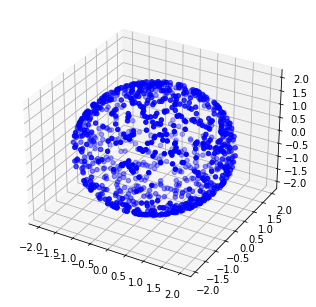

In [78]:
# 可视化
fig=plt.figure()
ax=Axes3D(fig)
ax.scatter(x,y,z,c='b')

/home/ma-user/work/anaconda3/envs/yzl_py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  # This is added back by InteractiveShellApp.init_path()


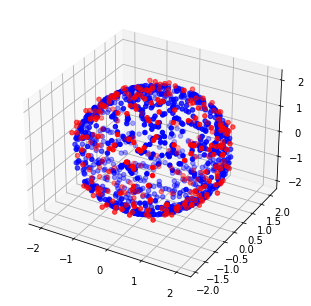

In [79]:
# 给30%的点添加噪声后可视化,其中红色的是带噪音的点
x_nosi=[]
y_nosi=[]
z_nosi=[]
slice=random.sample(range(npoints),int(0.3*npoints))
for i in slice:
    x_nosi.append(x[i]+0.1*choice(flag))
    y_nosi.append(y[i]+0.1*choice(flag))
    z_nosi.append(z[i]+0.1*choice(flag))
fig=plt.figure()
ax=Axes3D(fig)
ax.scatter(x,y,z,c='b')
ax.scatter(x_nosi,y_nosi,z_nosi,c='r')

In [107]:
cnt=0
sphere_X=[]
sphere_Y=[]
for i in range(npoints):
    tmp_x=[]
    tmp=[]
    if i in slice:
        tmp_x.append(x_nosi[cnt])
        tmp_x.append(y_nosi[cnt])
        tmp.append(Tensor(tmp_x,ms.float32))
        tmp.append(Tensor(z_nosi[cnt],ms.float32))
        cnt+=1
    else:
        tmp_x.append(x[i])
        tmp_x.append(y[i])
        tmp.append(Tensor(tmp_x,ms.float32))
        tmp.append(Tensor(z[i],ms.float32))
    sphere_X.append(tmp)   

In [108]:
train_size=int(npoints*0.9)
train_sphere_X=sphere_X[:train_size]
test_sphere_X=sphere_X[train_size:]

In [116]:
test_x=[]
test_y=[]
for i in range(int(train_size),npoints):
    test_x.append(sphere_X[i][0].asnumpy())
    test_y.append(sphere_X[i][1])
print(len(test_x),len(test_y))    

100 100


In [117]:
test_x[0]

array([1.522351  , 0.56508934], dtype=float32)

In [110]:
train_sphere_X=create_dataset(train_sphere_X)

In [ ]:
cnt=0
for i in train_sphere_X.create_dict_iterator():
    print(i["data"],i["label"])
    cnt+=1
    if cnt==10:
        break

In [111]:
# 这一步跑了1分半
epochs=30
model.train(epochs,train_sphere_X,dataset_sink_mode=False)
metrics=model.eval(train_sphere_X,dataset_sink_mode=False)

In [113]:
test_x[0]

Tensor(shape=[2], dtype=Float32, value= [ 1.52235103e+00,  5.65089345e-01])

In [121]:
test_x[0]

array([1.522351  , 0.56508934], dtype=float32)

In [119]:
predict_sphere=model.predict(Tensor(test_x))
mse_sphere=0
for i in range(len(predict_sphere)):
    mse_sphere+=(predict_sphere[i]-test_y[i])**2
mse_sphere/=100
print(mse_sphere)    

[1.6939988]
